# General 2-planet system

Derive the precession mode frequencies and amplitudes for a generic, closely-packed, 2-planet system. By generic, we mean that each planet has a generic set of initial conditions for (mass, semimajor axis, inclination).

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

# Method 1: Simulation

In [2]:
# initialize inclinations
rng = default_rng()
inc_scale = 1.8 * np.pi / 180 # inclination scale in radians

# b_inc_0_rad = rng.rayleigh(scale=inc_scale)
# c_inc_0_rad = rng.rayleigh(scale=inc_scale)
b_inc_0_rad = 0.039505988
c_inc_0_rad = 0.069253338
print(f'b_inc_0_rad = %.9f' % b_inc_0_rad)
print(f'c_inc_0_rad = %.9f' % c_inc_0_rad)

b_inc_0_rad = 0.039505988
c_inc_0_rad = 0.069253338


In [3]:
## Initialize simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

M_e = 3.00273e-6 # Earth mass in Msun

star_mass = 1.0
P_ratio = 1.51

# Each planet has 3 provided params: mass (m) in Earth masses, semimajor axis (a), 
# and inclination (inc). The four omitted orbital params (e, f, omega, Omega) 
# are left at their default values of 0.
b_params = {
    "m": 4.19 * M_e, 
    "a": 0.0719, 
    "inc": b_inc_0_rad,
    "Omega": 0
}

c_params = {
    "m": 4.16 * M_e, 
    "a": b_params['a'] * P_ratio**(2/3), # a \propto P^(2/3)
    "inc": c_inc_0_rad,
    "Omega": np.pi
}

sim.add(m=star_mass)
sim.add(m=b_params['m'], a=b_params['a'], inc=b_params['inc'], Omega=b_params['Omega'])
sim.add(m=c_params['m'], a=c_params['a'], inc=c_params['inc'], Omega=c_params['Omega'])

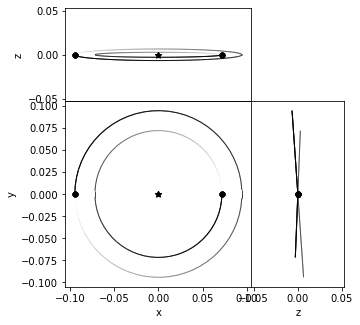

In [4]:
op_set = rebound.OrbitPlotSet(sim)

In [6]:
Lx, Ly, Lz = sim.angular_momentum()
Lx, Ly, Lz

(2.046058699737648e-22, 8.335372514136286e-07, 4.526580337265717e-05)

## Run sim

Per Appendix 1 in Su & Lai (2022), we track complex inclination $\mathcal{I}_j \equiv I_j \text{exp}(i \Omega_j)$.

In [30]:
tstep = 1
tmax = 2e3 # end time of integration (yr)
num_steps = int(tmax / tstep)

b_incs_rad = np.asarray([0.] * num_steps) # inclination (radians) of Planet B over the sim
c_incs_rad = np.asarray([0.] * num_steps) # inc (radians) of Planet C over the sim

b_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet B over the sim
c_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet C over the sim

b_as = np.asarray([0.] * num_steps) # semimajor axis of Planet B over the simulation
c_as = np.asarray([0.] * num_steps) # a of Planet C over the simulation

times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    inc_b = sim.particles[1].inc
    inc_c = sim.particles[2].inc
    b_incs_rad[i] = inc_b
    c_incs_rad[i] = inc_c
    
    # update complex inclination arrays
    Omega_i_b = sim.particles[1].Omega
    Omega_i_c = sim.particles[2].Omega
    b_complex_incs_rad[i] = inc_b * np.exp(1j * Omega_i_b)
    c_complex_incs_rad[i] = inc_c * np.exp(1j * Omega_i_c)
    
    # update semimajor axis arrays
    b_as[i] = sim.particles[1].a
    c_as[i] = sim.particles[2].a
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

Integration took 44.8 seconds


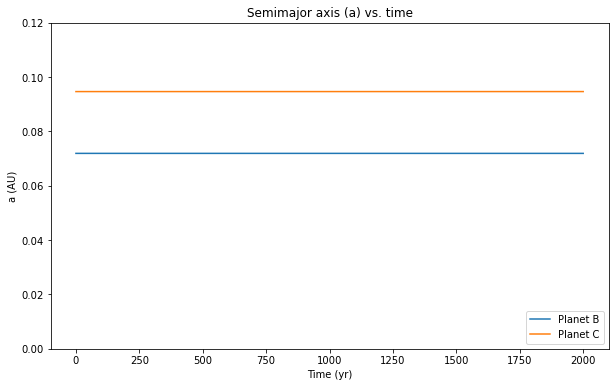

In [31]:
# check that semimajor axes aren't wandering
fig = plt.figure(figsize=(10,6))

plt.plot(times, b_as, label='Planet B')
plt.plot(times, c_as, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('a (AU)')
plt.ylim(0, .12)

plt.title('Semimajor axis (a) vs. time')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# convert inclinations from radians to degrees
b_incs_deg = b_incs_rad * (180 / np.pi)
c_incs_deg = c_incs_rad * (180 / np.pi)
b_complex_incs_deg = b_complex_incs_rad * (180 / np.pi)
c_complex_incs_deg = c_complex_incs_rad * (180 / np.pi)

# save data
file_path = f'bc_complex_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, b_complex_incs_deg, c_complex_incs_deg), f)

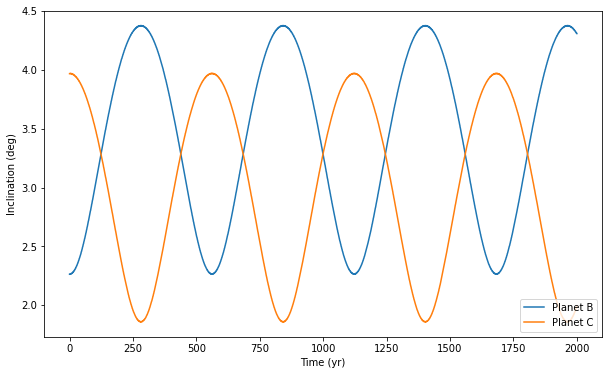

In [7]:
# load in data, if necessary
load_data = True
if load_data:
    tstep = int(1)
    tmax = 2e3
    num_steps = int(tmax)
    N = int(num_steps)

    file_path = f'bc_complex_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, b_complex_incs_deg, c_complex_incs_deg = pickle.load(f)

b_incs_deg = np.abs(b_complex_incs_deg)
c_incs_deg = np.abs(c_complex_incs_deg)

fig = plt.figure(figsize=(10,6))

plt.plot(times, b_incs_deg, label='Planet B')
plt.plot(times, c_incs_deg, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination (deg)')

plt.legend(loc='lower right')
plt.show()

## Amplitudes (basic estimate)

In [53]:
b_amp_basic = (np.max(b_incs_deg) - np.min(b_incs_deg)) / 2
c_amp_basic = (np.max(c_incs_deg) - np.min(c_incs_deg)) / 2

print(f'B amp (basic): %.3f deg' % b_amp_basic)
print(f'C amp (basic): %.3f deg' % c_amp_basic)

B amp (basic): 1.057 deg
C amp (basic): 1.057 deg


## Apply FFT to sim data

In [ ]:
def FFT_period_amp(incs, planet_name):
    '''
    Given a time series for a planet's inclination (incs), return the period
    and amplitude of the time series. NOTE: This implementation is for 2 planets.
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 0.01)
    plt.title('FFT for ' + planet_name)
    plt.show()

    # return period (years) and amplitude (degrees)
    return 1 / xf[np.argmax(yf)], yf_scaled[np.argmax(yf)]

b_period, b_amp = FFT_period_amp(b_incs_deg, 'Planet B')
c_period, c_amp = FFT_period_amp(c_incs_deg, 'Planet C')

print(f'Planet B period: %0.f years' % b_period)
print(f'Planet B amplitude: %0.3f deg' % b_amp)
print(f'Planet C period: %0.f years' % c_period)
print(f'Planet C amplitude: %0.3f deg' % c_amp)

### Quadratic interpolation w/ FFT result

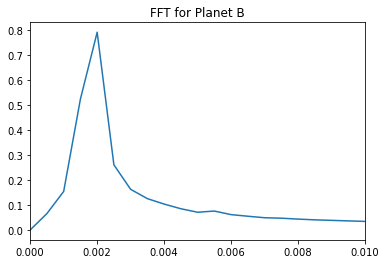

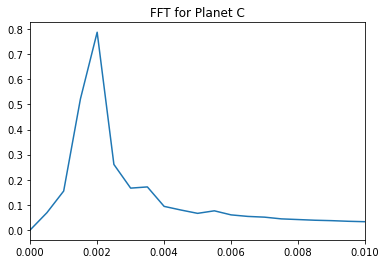

Planet B period (w/ interp): 522 years
Planet B amplitude (w/ interp): 0.802 deg
Planet C period (w/ interp): 521 years
Planet C amplitude (w/ interp): 0.799 deg


In [8]:
def quad_fn(coeffs, x):
    '''
    
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

def FFT_period_amp_interp(incs, planet_name):
    '''
    Given a time series for a planet's inclination (incs), interpolate near
    the peak of the FFT transform and return the period and amplitude of the time series.
    NOTE: This implementation is for 2 planets.
    
    This is essentially the function FFT_period_amp implemented with
    the quadratic interpolation.
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 0.01)
    plt.title('FFT for ' + planet_name)
    plt.show()
    
    x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
    y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
    y_vals_scaled = 2 / num_steps * np.abs(y_vals)

    # get coefficients of the interpolated quadratic function
    coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)
    a, b, c = coeffs
    
    # get mode freq and amplitude
    mode_f = - b / (2*a) # peak of the quadratic function
    mode_amp = quad_fn(coeffs, mode_f)

    # return period (years) and amplitude
    return 1 / mode_f, mode_amp

b_period_interp, b_amp_interp = FFT_period_amp_interp(b_incs_deg, 'Planet B')
c_period_interp, c_amp_interp = FFT_period_amp_interp(c_incs_deg, 'Planet C')

print(f'Planet B period (w/ interp): %0.f years' % b_period_interp)
print(f'Planet B amplitude (w/ interp): %0.3f deg' % b_amp_interp)
print(f'Planet C period (w/ interp): %0.f years' % c_period_interp)
print(f'Planet C amplitude (w/ interp): %0.3f deg' % c_amp_interp)

## Sanity check

Do a sanity check with `scipy.optimize`. See [this link](https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html).

[1.04075213 0.0112046  1.55650639 3.00866034]


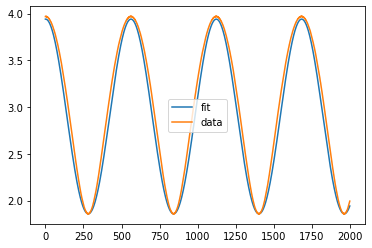

In [41]:
def test_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

guess = [4, .011, 0.1, 3.25]
params, params_covariance = optimize.curve_fit(test_func, times, c_incs_deg,
                                               p0=guess)
print(params)

a, b, c, d = params
plt.plot(times, test_func(times, a, b, c, 2.9), label='fit')
plt.plot(times, c_incs_deg, label='data')
plt.legend()
plt.show()

# Analytic formula

I check that the mode frequency formula (Su & Lai 2022, Equation A2) matches our simulation's frequencies.

In [9]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or const.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [10]:
planet_inds = ['b', 'c']

# calculate omega_jk values in yr^-1 (but without the unit)
# format: omega_jk = mode_freq(j_params['a']*u.au, k_params['a']*u.au, \
    # k_params['m']*const.M_sun, star_mass*const.M_sun).to(u.yr**-1).value
for j in planet_inds:
    for k in planet_inds:
        if (j == k): continue
        exec('omega_' + j + k + ' = ' + \
             'mode_freq(' + j + "_params['a']*u.au, " + k + "_params['a']*u.au, " + \
             k + "_params['m']*const.M_sun, star_mass*const.M_sun).to(u.yr**-1).value")

## NOTE: This implementation is for 2 planets.
mat = np.array([
    [-omega_bc, omega_bc],
    [omega_cb, -omega_cb]
])
 
eigs, eigvs = np.linalg.eig(mat)
prec_freq = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigv = eigvs[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigv = np.squeeze(prec_eigv).T # reshape to (2,), ie each row is an eigv
zero_mode_ind = np.where(np.abs(eigs) < 1e-10)[0] # index of mode w/ frequency=0

# Note: for 2 planets, prec_freq = -(w_js + w_sj)
print(f'Period: %.2f years' % (2 * np.pi / (-prec_freq)))
print(f'Non-zero mode frequencies: {prec_freq}')
print(f'Corresponding mode eigenvectors: {prec_eigv}')

Period: 484.67 years
Non-zero mode frequencies: [-0.01296382]
Corresponding mode eigenvectors: [-0.75148311  0.65975233]


In [148]:
np.linalg.eig?

In [151]:
print(eigs)
print(eigvs)

[-0.01296382  0.        ]
[[-0.75148311 -0.70710678]
 [ 0.65975233 -0.70710678]]


In [35]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector: {np.matmul(mat, np.squeeze(prec_eigv)) / prec_eigv}")
print(f'Eigenvalues: {eigs}')

Matrix "divided" by eigenvector: [-0.01296382 -0.01296382]
Eigenvalues: [-0.01296382  0.        ]


## Mode amplitudes (attempt 2)

The system of equations is:
$$\begin{equation} I_1(t) = c_1 I_1^{(1)} + c_2 I_1^{(2)}e^{i\omega t} \\
I_2(t) = c_1 I_2^{(1)} + c_2 I_2^{(2)}e^{i\omega t}
\end{equation}$$

Let B be the eigenvectors matrix: 
$$B = \begin{pmatrix}
\vec{I}^{(1)} & \vec{I}^{(2)}
\end{pmatrix}
=
\begin{pmatrix}
I_1^{(1)} & I_1^{(2)} \\
I_2^{(1)} & I_2^{(2)}
\end{pmatrix}$$

Then:
$$\begin{pmatrix}
I_1^{(1)} & I_1^{(2)} \\
I_2^{(1)} & I_2^{(2)}
\end{pmatrix} 
\begin{pmatrix}
c_1 \\
c_2
\end{pmatrix} 
=
\begin{pmatrix}
i_\text{init, 1} \\
i_\text{init, 2}
\end{pmatrix}
\iff 
B \vec{c} = \vec{i}_\text{init}$$

The mode amplitude is $\left| c_2 \vec{I}^{(2)} \right|$.

In [15]:
# np.dot doesn't take conjugates of vectors

temp_a = np.array([[1j, 2j],
         [2j, 1j]])
temp_b = np.array([[1j], 
                  [2j]])

np.dot(temp_a, temp_b)

array([[-5.+0.j],
       [-4.+0.j]])

In [144]:
eigvs_mat = eigvs[:, [1, 0]]
print(f'eigvs_mat: {eigvs_mat}')

temp_i = 5
incs_init_deg = np.array([b_complex_incs_deg[temp_i], c_complex_incs_deg[temp_i]])
print(f'incs_init_deg: {incs_init_deg}')

c = np.linalg.solve(eigvs_mat, incs_init_deg)
print(f'c: {c}')

# check solution correctness:
print(f'Solution correct? {np.allclose(np.dot(eigvs_mat, c), incs_init_deg)}')

eigvs_mat: [[-0.70710678 -0.75148311]
 [-0.70710678  0.65975233]]
incs_init_deg: [ 2.26457327-0.14911133j -3.96866627+0.13097191j]
c: [ 1.49146899-4.67283049e-05j -4.41686721+1.98466705e-01j]
Solution correct? True


In [147]:
print('average inclinations?:')
print(np.abs(c[1] * eigvs_mat[:,1]))
print('mode amps?:')
print(np.abs(c[0] * eigvs_mat[:,0]))

average inclinations?:
[3.32255022 2.91697874]
mode amps?:
[1.05462783 1.05462783]


## sanity check

Do the derived coefficients (c_1, c_2) actually correspond to the coefficients in the equations written above?

In [116]:
prec_freq

array([-0.01296382])

In [120]:
c[1]*eigvs_mat[0,1]*np.exp(1j*prec_freq*t_series)

array([3.3192011 -0.14914438j, 3.31698876-0.19216017j,
       3.31421898-0.23514367j, ..., 2.3126647 -2.38556533j,
       2.2815452 -2.41534501j, 2.25004226-2.44471876j])

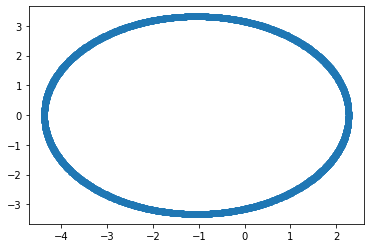

In [132]:
plt.scatter(np.real(b_temp_series), np.imag(b_temp_series))

So for the planet B series, it looks like I have something centered on -1+0j that has a radius of ~3. Meanwhile, the equations are expecting something centered on 3+0j that has a radius of ~1.

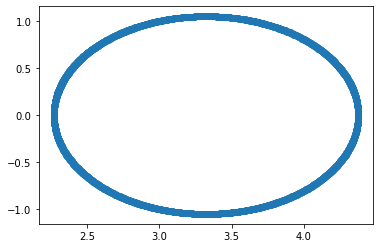

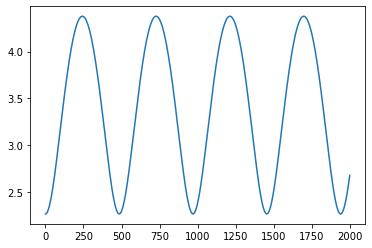

In [137]:
expected_temp_series = np.ones((2000))*np.abs(c[1]*eigvs_mat[0,1]) + c[0]*eigvs_mat[0,0]*np.exp(1j*prec_freq*t_series)

plt.scatter(np.real(expected_temp_series), np.imag(expected_temp_series))
plt.show()

plt.plot(np.abs(expected_temp_series))
plt.show()

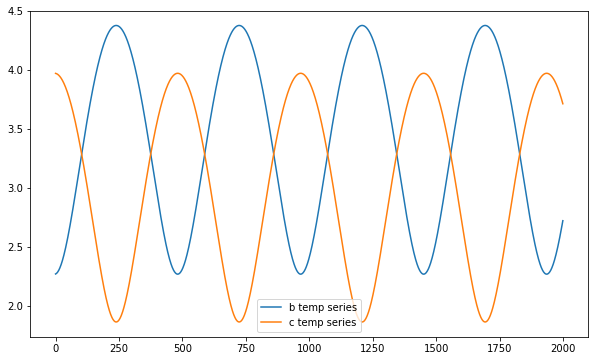

In [129]:
t_series = np.arange(2000)

b_temp_series = np.ones((2000))*c[0]*eigvs_mat[0,0] + c[1]*eigvs_mat[0,1]*np.exp(1j*prec_freq*t_series)
c_temp_series = np.ones((2000))*c[0]*eigvs_mat[1,0] + c[1]*eigvs_mat[1,1]*np.exp(1j*prec_freq*t_series)

plt.figure(figsize=(10,6))
plt.plot(np.abs(b_temp_series), label='b temp series')
plt.plot(np.abs(c_temp_series), label='c temp series')

plt.legend()
plt.show()

My idea is that our derived solution for $c_1, c_2$ corresponds to this system of equations:
$$\begin{equation} I_1(t) = e^{i\omega t} \left( c_1 I_1^{(1)} e^{-i\omega t} + c_2 I_1^{(2)} \right)\\
I_2(t) = e^{i\omega t} \left( c_1 I_2^{(1)} e^{-i\omega t} + c_2 I_2^{(2)}\right)
\end{equation}$$
Since we only care about the magnitudes of $I_{1,2}$, the outside factor of $e^{i\omega t}$ doesn't influence the solution for $c_1, c_2$, so we end up with two solutions instead of a unique one.

## Mode amplitudes (attempt 1; doesn't work)

Calculate mode amplitudes given the initial complex inclination vector $\vec{\mathcal{I}}_0$ (which has $n$ entries) and the eigenvectors. 

Let $n$ be the number of planets. Reading from Eq. A1 in Su & Lai (2022), the eigenvalue problem can be written as:

$$ \frac{d\vec{\mathcal{I}}}{dt} = i\sum_{k=1}^{n-1} g_k \left(\vec{\mathcal{I}}_0 \cdot \frac{\vec{v}_k}{|\vec{v}_k|}\right)\vec{v}_k = i\sum_{k=1}^{n-1} g_k \left(\vec{\mathcal{I}}_0 \cdot \vec{v}_k\right)\vec{v}_k \equiv \sum_{k=1}^{n-1} g_k \vec{A}_k.$$

The second-to-last step comes from the fact that the eigenvectors are normalized, so $|\vec{v}_k| = 1$. The goal is to find the $n-1$ mode amplitudes, each of which is defined as $\vec{A}_k \equiv i\left(\vec{\mathcal{I}}_0 \cdot \vec{v}_k\right)\vec{v}_k$.

To get the complex inclination variation for a given planet $n$, we take the $n$th component of the above equation:

$$ \frac{d\mathcal{I}_n}{dt} = \sum_{k=1}^{n-1} g_k \left(\mathcal{I}_{0, n} v_{k, n}\right)v_{k,n} \equiv \sum_{k=1}^{n-1} g_k A_{k,n}.$$



The inclination variation is simply $I_n = |\mathcal{I}_n|$.

In [180]:
def get_mode_amps(complex_inc_0, eigvs, zero_mode_ind):
    '''
    Given the initial complex inclination vector inc_0 and the set of 
    eigenvectors (eigvs) for a system, compute the mode amplitudes 
    (which are the projections of inc_0 onto the eigenvectors). NOTE: In the below
    calculation, the eigenvector with eigenvalue 0 is set to the zero vector.
    (The index of this eigenvector is given by zero_mode_ind.)
    
    Let n be the number of planets. inc_0 has shape (n,), and eigvs has shape
    (n, n), where the columns (i.e. eigvs[:,i]) are the eigenvectors. The output 
    will have shape (n, n), and the ith column corresponds to mode amplitude i.
    (The column at A_vecs[:,zero_mod_ind] will be the zero vector.)
    
    
    '''
    
    n = len(complex_inc_0)
    complex_inc_0 = np.expand_dims(complex_inc_0, axis=1) # change shape to (n, 1)
    eigvs[:,zero_mode_ind] = np.zeros((n, 1))
    
    scalars = np.matmul(np.conj(complex_inc_0.T), eigvs) # complex inner product 
    diag_mat = np.zeros((n,n), dtype=complex)
    np.fill_diagonal(diag_mat, scalars)
    A_vecs = 1j * np.matmul(eigvs, diag_mat)
    
    print(f'complex_inc_0.T: {complex_inc_0}')
    print(f'scalars: {scalars}')
    print(f'diag_mat: {diag_mat}')
    
    return A_vecs

In [179]:
temp_i = 0
inc_0_temp = np.asarray([b_complex_incs_deg[temp_i], c_complex_incs_deg[temp_i]])
mode_amps = get_mode_amps(inc_0_temp, eigvs, zero_mode_ind)
print('Mode amplitudes:')
print(mode_amps)
print('Magnitudes of mode amplitudes:')
print(np.abs(mode_amps))

complex_inc_0.T: [[ 2.26352636+0.00000000e+00j]
 [-3.96792401+4.85930544e-16j]]
scalars: [[-4.31884894+3.20593809e-16j  0.        +0.00000000e+00j]]
diag_mat: [[-4.31884894+3.20593809e-16j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j]]
Mode amplitudes:
[[ 2.40920832e-16+3.24554203j  0.00000000e+00+0.j        ]
 [-2.11512513e-16-2.84937065j  0.00000000e+00+0.j        ]]
Magnitudes of mode amplitudes:
[[3.24554203 0.        ]
 [2.84937065 0.        ]]
